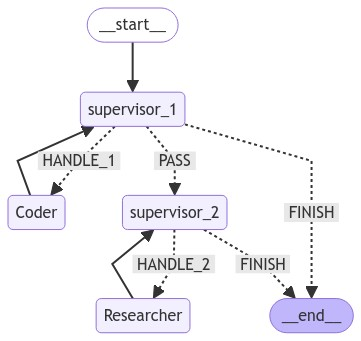

{'supervisor_1': {'next': 'HANDLE_1'}}
----
{'Coder': {'messages': [HumanMessage(content='The result of \\( 123 \\times 456 \\) is \\( 56088 \\).', name='Coder')]}}
----
{'supervisor_1': {'next': 'FINISH'}}
----


In [4]:
import getpass
import os
import functools
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
from langchain_experimental.tools import PythonREPLTool
from langchain_core.tools import tool
from pydantic import BaseModel
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver


# Environment setup
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

os.environ["OPENAI_API_KEY"] = "my-key"

python_repl_tool = PythonREPLTool()

llm = ChatOpenAI(model="gpt-4o")

@tool
def gpt_search(query: str) -> str:
    """
    検索ツール
    """
    ai_msg = llm.invoke(query)
    return ai_msg

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

members = ["Researcher", "Coder"]

# Define the supervisor prompts
system_prompt_1 = (
    "You are the first supervisor responsible for handling tasks related to code execution."
    " Given the user request, determine if it is related to code execution and should be handled by you."
    " If yes, call Coder and show the result, then respond with FINISH"
    " If not, pass the request to the second supervisor."
)

system_prompt_2 = (
    "You are the second supervisor responsible for handling tasks related to research."
    " Given the request from first supervisor, determine if it is related to research and should be handled by you."
    "if yes, call Researcher and show the response, then respond with FINISH"
    " If not, respond with FINISH."
)

# Define prompts
prompt_1 = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_1),
        MessagesPlaceholder(variable_name="messages"),
        ("system", "Should this request be handled by you or passed to the second supervisor? Select one of: {options}"),
    ]
).partial(options=["HANDLE_1", "PASS", "FINISH"])

prompt_2 = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_2),
        MessagesPlaceholder(variable_name="messages"),
        ("system", "Should this request be handled by you or responded with FINISH? Select one of: {options}"),
    ]
).partial(options=["HANDLE_2", "FINISH"])

# Define response models
class routeResponse(BaseModel):
    next: Literal["PASS", "HANDLE_1", "FINISH"]

class routeResponse2(BaseModel):
    next: Literal["FINISH", "HANDLE_2"]

# Define supervisor agents
def supervisor_agent_1(state):
    supervisor_chain = (
        prompt_1
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

def supervisor_agent_2(state):
    supervisor_chain = (
        prompt_2
        | llm.with_structured_output(routeResponse2)
    )
    return supervisor_chain.invoke(state)

class AgentState(TypedDict):
    messages: Annotated[Sequence[HumanMessage], operator.add]
    next: str

research_agent = create_react_agent(llm, tools=[gpt_search])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor_1", supervisor_agent_1)
workflow.add_node("supervisor_2", supervisor_agent_2)

workflow.add_edge("Coder", "supervisor_1")
# workflow.add_edge("supervisor_1", "supervisor_2")
workflow.add_edge("Researcher", "supervisor_2")

conditional_map_1 = {
    "HANDLE_1": "Coder",
    "PASS": "supervisor_2",
    "FINISH": END
}
workflow.add_conditional_edges("supervisor_1", lambda x: x["next"], conditional_map_1)

conditional_map_2 = {
    "HANDLE_2": "Researcher",
    "FINISH": END
}
workflow.add_conditional_edges("supervisor_2", lambda x: x["next"], conditional_map_2)

workflow.add_edge(START, "supervisor_1")

memory = MemorySaver()

graph = workflow.compile()

from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

if __name__ == '__main__':
    # for s in graph.stream(
    #     {"messages": [HumanMessage(content="code hello world and show it on the terminal")]},
    #     {"recursion_limit": 100},
    # ):
    #     if "__end__" not in s:
    #         print(s)
    #         print("----")
    for s in graph.stream(
#        {"messages": [HumanMessage(content="what is the smallest country in the world")]},
        {"messages": [HumanMessage(content="calculate 123 * 456 = ? and display the result")]},
        {"recursion_limit": 100},
    ):
        if "__end__" not in s:
            print(s)
            print("----")